In [1]:
# Importing necessary libraries for data analysis and visualization
import numpy as np               # NumPy for numerical operations
import pandas as pd              # Pandas for data manipulation and analysis
import matplotlib.pyplot as plt  # Matplotlib for basic plotting
import seaborn as sns            # Seaborn for statistical data visualization

##Data Preprocessing

In [2]:
df = pd.read_csv("LSTM-Multivariate_pollution.csv")

In [3]:
# Displaying the first few rows of the DataFrame to get a quick overview of the data
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [5]:
missing_values = df.isna().sum()
print(missing_values)

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64


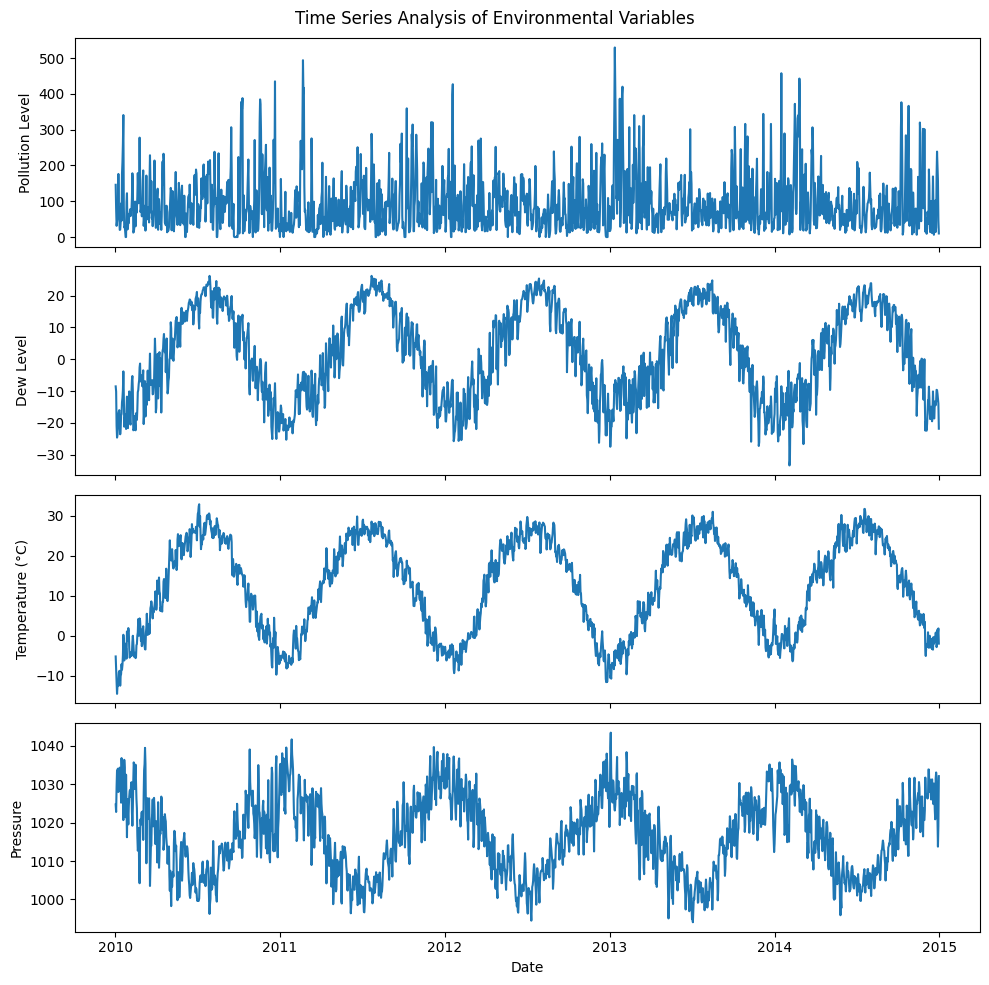

In [5]:
# Ensure that 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Exclude 'wnd_dir' from downsampled DataFrame
df_downsampled = df.drop(columns=['wnd_dir']).resample('D', on='date').mean()

# Reset index to make 'date' a regular column
df_downsampled = df_downsampled.reset_index()

# Create a figure with subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Plot each variable over time
axs[0].plot(df_downsampled['date'], df_downsampled['pollution'], label='Pollution')
axs[0].set_ylabel('Pollution Level')


axs[1].plot(df_downsampled['date'], df_downsampled['dew'], label='Dew')
axs[1].set_ylabel('Dew Level')


axs[2].plot(df_downsampled['date'], df_downsampled['temp'], label='Temperature')
axs[2].set_ylabel('Temperature (°C)')


axs[3].plot(df_downsampled['date'], df_downsampled['press'], label='Pressure')
axs[3].set_ylabel('Pressure')

# Set common xlabel
axs[-1].set_xlabel('Date')

# Add a title to the entire plot
plt.suptitle('Time Series Analysis of Environmental Variables')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

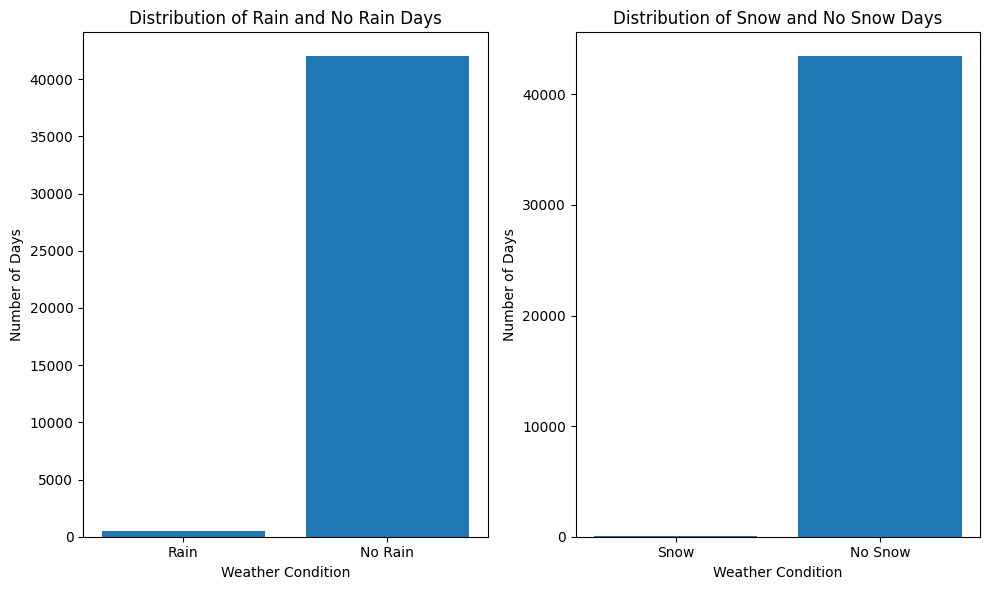

In [6]:
# Weather conditions to plot
conditions = ["rain", "snow"]

# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

for i, condition in enumerate(conditions, 1):
    # Filter days for the current condition
    condition_days = list(filter(lambda x: x == 1, df[condition].to_numpy()))
    no_condition_days = list(filter(lambda x: x == 0, df[condition].to_numpy()))

    # Create a bar plot for the current condition
    axs[i - 1].bar([f"{condition.capitalize()}", f"No {condition.capitalize()}"],
                   [len(condition_days), len(no_condition_days)])
    axs[i - 1].set_xlabel("Weather Condition")
    axs[i - 1].set_ylabel("Number of Days")
    axs[i - 1].set_title(f"Distribution of {condition.capitalize()} and No {condition.capitalize()} Days")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

In [7]:
df.drop(columns=["snow", "date"], inplace=True)

In [8]:
from sklearn.preprocessing import OneHotEncoder

# Creating an instance of the OneHotEncoder
enc = OneHotEncoder()

# Encoding the specified categorical column and creating a new DataFrame with the encoded features
categorical_column = "wnd_dir"
encoded_data = enc.fit_transform(df[[categorical_column]])
cols = enc.get_feature_names_out(input_features=[categorical_column])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=cols)

# Concatenating the original DataFrame with the encoded DataFrame along the columns
df = pd.concat([df, encoded_df], axis=1)

# Dropping the original categorical column from the DataFrame
df = df.drop(columns=[categorical_column])

In [10]:
# Setting the time interval for creating temporal sequences (7 days * 24 hours)
t_i = 7 * 24

# Creating input sequences (X_tmp) and target values (y_tmp) for a time series prediction task
# Each input sequence is a window of length t_i (7 days * 24 hours)
X_tmp = np.array([df[i:i+t_i].drop(columns=["pollution"]).to_numpy() for i in range(len(df)-t_i)])

# Each target value corresponds to the pollution level after the respective input sequence
y_tmp = np.array([df.iloc[i+t_i]["pollution"] for i in range(len(df)-t_i)])

In [11]:
# Determining the index to split the data into training and validation sets (80% for training)
i = int(len(df) * 0.8)

# Splitting the input sequences (X_tmp) and target values (y_tmp) into training and validation sets
# Training set includes the first i samples, while the validation set includes the remaining samples
X_train, y_train = X_tmp[:i, :], y_tmp[:i]
X_val, y_val = X_tmp[i:, :], y_tmp[i:]

In [12]:
# Calculating mean and standard deviation for standardization of features in the training set
X_train_mean = X_train.mean()
X_train_std = X_train.std()

# Standardizing features in the training and validation sets based on the training set statistics
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std

# Calculating mean and standard deviation for standardization of target values in the training set
y_train_mean = y_train.mean()
y_train_std = y_train.std()

# Standardizing target values in the training and validation sets based on the training set statistics
y_train = (y_train - y_train_mean) / y_train_std
y_val = (y_val - y_train_mean) / y_train_std

##Training

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Creating a sequential model
model = Sequential()

# Adding the first LSTM layer with 64 units, returning sequences, and specifying input shape
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# Adding dropout regularization to prevent overfitting
model.add(Dropout(0.2))

# Adding a second LSTM layer with 32 units and not returning sequences
model.add(LSTM(32, return_sequences=True))

# Adding dropout regularization to prevent overfitting
model.add(Dropout(0.2))

# Adding a second LSTM layer with 16 units and not returning sequences
model.add(LSTM(16, return_sequences=False))

# Adding a dense output layer with 1 unit (regression problem)
model.add(Dense(units=1))

# Compiling the model with the Adam optimizer and mean squared error loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the model on the training data and validating on the validation data
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
1095/1095 [==============================] - 185s 164ms/step - loss: 0.9278 - val_loss: 0.9097
Epoch 2/5
1095/1095 [==============================] - 183s 167ms/step - loss: 0.8562 - val_loss: 0.7343
Epoch 3/5
1095/1095 [==============================] - 190s 174ms/step - loss: 0.8330 - val_loss: 0.8990
Epoch 4/5
1095/1095 [==============================] - 237s 216ms/step - loss: 0.7423 - val_loss: 0.6015
Epoch 5/5
1095/1095 [==============================] - 208s 190ms/step - loss: 0.6863 - val_loss: 0.6823


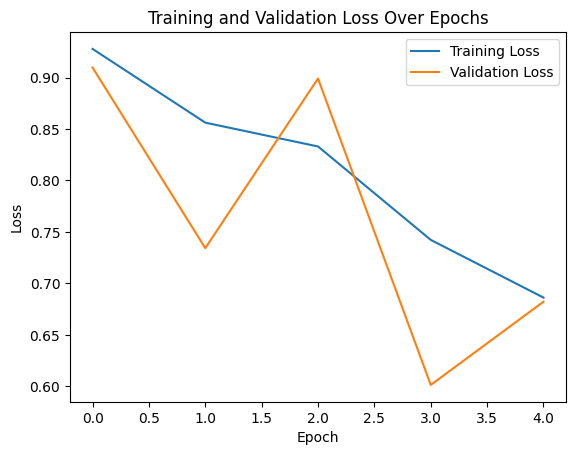

In [16]:
plt.plot(history.history['loss'], label='Training Loss')      # Plotting training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plotting validation loss

# Adding labels to the axes
plt.xlabel('Epoch')    # Label for the x-axis
plt.ylabel('Loss')      # Label for the y-axis

# Adding a legend to distinguish between training and validation loss
plt.legend()

# Adding a title to the plot
plt.title('Training and Validation Loss Over Epochs')

# Displaying the plot
plt.show()

##Test-Data Preprocessing

In [17]:
df1 = pd.read_csv("pollution_test_data1.csv")

In [18]:
df1.head()

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93


In [19]:
missing_values = df1.isna().sum()
print(missing_values)

dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
pollution    0
dtype: int64


In [20]:
df1.drop(columns=["snow"], inplace=True)

encoded_data = enc.transform(df1[[categorical_column]])
cols = enc.get_feature_names_out(input_features=[categorical_column])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=cols)
df1 = pd.concat([df1, encoded_df], axis=1)
df1 = df1.drop(columns=[categorical_column])

X_test = np.array([df1[i:i+t_i].drop(columns=["pollution"]).to_numpy() for i in range(len(df1)-t_i)])
y_test = np.array([df1.iloc[i+t_i]["pollution"] for i in range(len(df1)-t_i)])

X_test = (X_test - X_train_mean) / X_train_std
y_test = (y_test - y_train_mean) / y_train_std

##Inference

6/6 [==============================] - 1s 44ms/step
Mean Squared Error on Test Set: 7984.516191087458


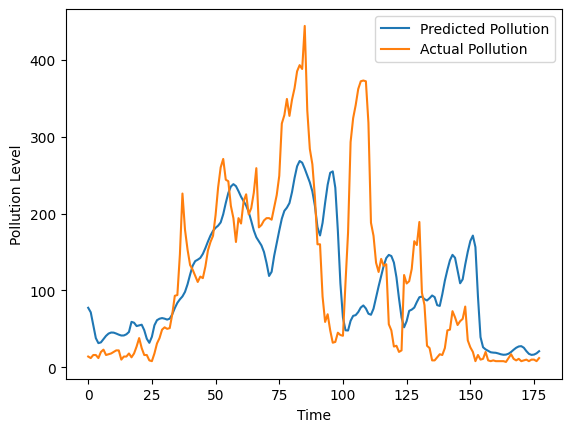

In [21]:
# Use the trained model to make predictions
predictions = model.predict(X_test)

# Reverse the standardization process for predictions and actual values
predictions = predictions * y_train_std + y_train_mean
y_test = y_test * y_train_std + y_train_mean

# Calculate the mean squared error (MSE)
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)

# Print the calculated loss
print(f'Mean Squared Error on Test Set: {mse}')

# Visualize the predictions and actual values
plt.plot(predictions, label='Predicted Pollution')
plt.plot(y_test, label='Actual Pollution')
plt.xlabel('Time')
plt.ylabel('Pollution Level')
plt.legend()
plt.show()